## Risk Analytics

In [287]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [288]:
%run Libraries.ipynb

In [289]:
%run Utility_tools.ipynb

In [627]:
raw = pd.read_csv('Risk_Analytics.csv') 
df = deepcopy(raw)

In [628]:
df.drop('Loan ID', axis=1, inplace=True)

In [629]:
df.rename(columns=lambda col: col.replace('?', '').replace(' ', '_').lower().strip(), inplace=True)

In [630]:
reduce_memory_usage(df)

Memory usage before: 39.88 MB
Memory usage now : 7.04 MB
Memory usage decreased by 82.3%


In [294]:
def plot_countplot(data):
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(9,7))
    ax = sns.countplot(data=data, x='payment')
    for p in ax.patches:
        total = len(data) 
        ax.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.25, p.get_height()+0.01))
    plt.show();

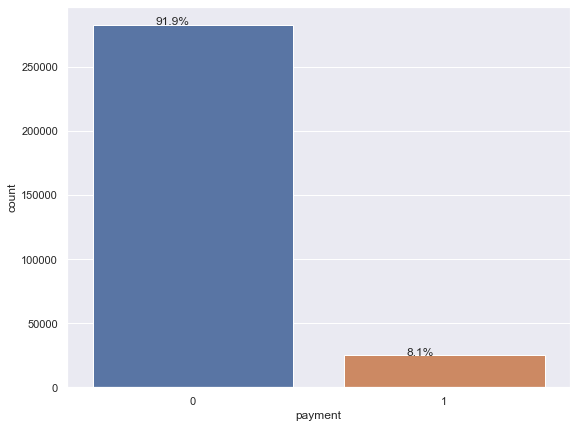

In [49]:
plot_countplot(df)

##### Fill in the missing

In [295]:
df.isna().sum()

payment                         0
loan_type                       0
gender                          0
have_a_car                      0
have_a_house                    0
number_of_children              0
total_income                    0
amount_of_credit                0
suite_type                   1292
income_type                     0
education_type                  0
family_status                   0
have_a_phone                    0
have_a_mail                     0
profession                  96391
number_of_family_members        2
organization                    0
dtype: int64

In [631]:
df[df['profession'].isna()].shape[0]/df.shape[0]

0.31345545362604915

In [632]:
df[~df['suite_type'].notna()].shape[0]/df.shape[0]

0.004201475719567756

In [633]:
df.drop('profession', axis=1, inplace=True)

In [634]:
df[df['number_of_family_members'].isna()]

,payment,loan_type,gender,have_a_car,have_a_house,number_of_children,total_income,amount_of_credit,suite_type,income_type,education_type,family_status,have_a_phone,have_a_mail,number_of_family_members,organization
41982,0,Revolving loans,M,N,Y,0,450000.0,675000.0,NaN,Commercial associate,Lower secondary,Unknown,1,0,NaN,Insurance
187348,0,Revolving loans,F,N,Y,0,202500.0,585000.0,NaN,Commercial associate,Higher education,Unknown,1,0,NaN,Business Entity Type 2


In [635]:
#I reckon there has to be a linear relationship between number_of_children and number_of_family_members.
df['number_of_children'].corr(df['number_of_family_members'])

0.8791606404389228

In [636]:
#As seen from above, our missing values of family members have no children.
df[df['number_of_children']==0]['number_of_family_members'].value_counts(normalize=True)*100
#So, we'll fill in the missing family members with 2.

2.0    68.497323
1.0    31.502677
Name: number_of_family_members, dtype: float64

In [637]:
df['number_of_family_members'].fillna(value=2, inplace=True)

In [638]:
#Checking the validity of the dataset
df[df['number_of_children']>df['number_of_family_members']]

,payment,loan_type,gender,have_a_car,have_a_house,number_of_children,total_income,amount_of_credit,suite_type,income_type,education_type,family_status,have_a_phone,have_a_mail,number_of_family_members,organization


In [497]:
#Let's fill in our last missing values column.
def plot_pie(data, column):
    plt.figure(figsize=(9,6))
    data[column].value_counts(normalize=True).plot(kind='pie')
    plt.show(); 

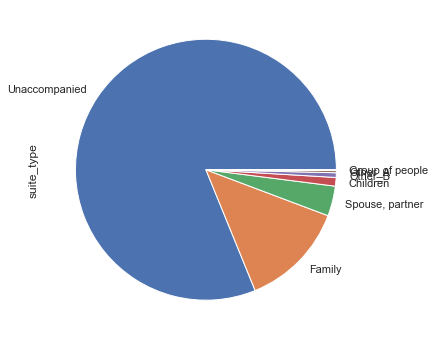

In [82]:
plot_pie(df, 'suite_type')

In [639]:
df['suite_type'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: suite_type, dtype: int64

In [640]:
df['suite_type'].fillna(value='Unaccompanied', inplace=True)

In [641]:
df.duplicated().sum()

15213

In [642]:
#Remove duplicate records
duplicate_check_remove(df)

Number of duplicate rows before: 15213
Number of duplicate rows now: 0


In [643]:
df.shape

(292298, 16)

#### 1. Feature Selection: Filtering
##### Let's determine which features to keep

#### 2. Feature Engineering
##### Creating new useful features

In [644]:
df_cont = df.select_dtypes(include='number')
df_cat = df.select_dtypes(include='category') 

In [645]:
df_cat['have_a_phone'] = df_cont['have_a_phone']  
df_cat['have_a_mail'] = df_cont['have_a_mail']
df_cat['number_of_children'] = df_cont['number_of_children'] 
df_cat['payment'] = df_cont['payment'] 
df_cat['number_of_family_members'] = df_cont['number_of_family_members'] 
df_cont['income_credit_ratio'] = df_cont['total_income'] / df_cont['amount_of_credit'] #engineered
df_cont.drop(['number_of_children', 'have_a_phone', 'have_a_mail', 'number_of_family_members'], axis=1, inplace=True)

In [646]:
df_cont.sample(4)

,payment,total_income,amount_of_credit,income_credit_ratio
32363,1,67500.0,521280.0,0.129489
239696,1,54000.0,156339.0,0.345403
47983,0,135000.0,942300.0,0.143266
280561,0,216000.0,1305000.0,0.165517


In [647]:
#Comparing means
pd.pivot_table(data=df_cont, index='payment', aggfunc=[np.mean ,np.median])  

mean                                              median  \
        amount_of_credit income_credit_ratio   total_income amount_of_credit   
payment                                                                        
0            608504.4375            0.402630  171268.515625         521280.0   
1            558076.6250            0.397245  165843.390625         497520.0   

                                          
        income_credit_ratio total_income  
payment                                   
0                  0.306620     157500.0  
1                  0.307692     135000.0

In [648]:
#Checking equal variances assumption. Mostly violated, so we continue with Welch T-test
pd.pivot_table(data=df_cont, index='payment', aggfunc=[np.var, 'count'])

var                                              count  \
        amount_of_credit income_credit_ratio  total_income amount_of_credit   
payment                                                                       
0           1.684205e+11            0.123358  1.263179e+10           267673   
1           1.204109e+11            1.849033  5.620305e+11            24625   

                                          
        income_credit_ratio total_income  
payment                                   
0                    267673       267673  
1                     24625        24625

##### Independent Sample T-test (Welch T)

In [650]:
for col in df_cont.columns[1:]:
    print(f'''P-value for {col}: {ttest(df_cont[df_cont['payment']==0][col], 
          df_cont[df_cont['payment']==1][col], correction='auto').T.iloc[3,:][0]} ''') 

P-value for total_income: 0.25663433686295833 
P-value for amount_of_credit: 1.7653363445999923e-101 
P-value for income_credit_ratio: 0.5355667560092505 


In [651]:
from sklearn.feature_selection import VarianceThreshold
print(df_cont.shape)     
var_filter = VarianceThreshold(threshold = 0.0)  
train = var_filter.fit_transform(df_cont)
print(train.shape)  #All of them remained       

(292298, 4)
(292298, 4)


In [652]:
find_outliers_iqr(df_cont)

Number of outlier records in total_income column: 13938
Number of outlier records in amount_of_credit column: 6502
Number of outlier records in income_credit_ratio column: 16955


In [653]:
def coerce_outliers(value):
    if value > upperlimit:
        value = upperlimit
    elif value < lowerlimit:
        value = lowerlimit
    return value

for feature in df_cont.columns[1:]:
    Q3 = df_cont[feature].quantile(q = 0.75)
    Q1 = df_cont[feature].quantile(q = 0.25)
    IQR = Q3 - Q1 
    outlier_range = IQR * 1.5
    upperlimit = Q3 + outlier_range
    lowerlimit = Q1 - outlier_range
    df_cont[feature] = df_cont[feature].apply(coerce_outliers)

In [654]:
df_cont.drop(['total_income', 'amount_of_credit'], axis=1, inplace=True)

##### Now, let's check which categorical and ordinal features are a good predictor for satisfaction. We'll conduct Chi-Square test for this

In [655]:
#We've got very few categories, but should we use one-hot encoding we'll end up with a lot of columns
for col in df_cat:
    print(f'''Number of unique values for {col}: {df_cat[col].nunique()}''') 

Number of unique values for loan_type: 2
Number of unique values for gender: 3
Number of unique values for have_a_car: 2
Number of unique values for have_a_house: 2
Number of unique values for suite_type: 7
Number of unique values for income_type: 8
Number of unique values for education_type: 5
Number of unique values for family_status: 6
Number of unique values for organization: 58
Number of unique values for have_a_phone: 2
Number of unique values for have_a_mail: 2
Number of unique values for number_of_children: 15
Number of unique values for payment: 2
Number of unique values for number_of_family_members: 17


In [672]:
a = list(df_cat.columns)

In [674]:
del a[-2]

In [676]:
for col in a:
    expected, observed, stats = chi2_independence(data=df, x=col, y='payment')
    print(stats)

                 test    lambda        chi2  dof          pval    cramer  \
0             pearson  1.000000  235.189733  1.0  4.401512e-53  0.028366   
1        cressie-read  0.666667  242.216794  1.0  1.292274e-54  0.028787   
2      log-likelihood  0.000000  257.532030  1.0  5.922218e-58  0.029683   
3       freeman-tukey -0.500000  270.241632  1.0  1.005187e-60  0.030406   
4  mod-log-likelihood -1.000000  284.127645  1.0  9.465289e-64  0.031178   
5              neyman -2.000000  315.967608  1.0  1.094613e-70  0.032878   

   power  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0  
5    1.0  
                 test    lambda        chi2  dof           pval    cramer  \
0             pearson  1.000000  786.287237  2.0  1.819265e-171  0.051865   
1        cressie-read  0.666667  778.735112  2.0  7.939972e-170  0.051616   
2      log-likelihood  0.000000  765.191590  2.0  6.930386e-167  0.051165   
3       freeman-tukey -0.500000         NaN  2.0            NaN       NaN   
4  mo

In [677]:
df_cat.drop(['loan_type', 'gender', 'have_a_car', 'have_a_phone',
             'suite_type', 'education_type', 'family_status', 'income_type',
            'organization', 'number_of_children', 'number_of_family_members'], axis=1, inplace=True)

In [678]:
df_cat = pd.concat([df_cat[df_cat['payment']==0].replace(0, 1), df_cat[df_cat['payment']==1].replace(1, 0)], 
         axis=0)

In [680]:
df_cat['have_a_house'] = df_cat['have_a_house'].replace('Y', 1).replace('N', 0)

In [681]:
df = pd.concat([df_cont.iloc[:,1:], df_cat], axis=1)

In [688]:
df.reset_index(drop=True, inplace=True)

In [690]:
df.tail()

,income_credit_ratio,have_a_house,have_a_mail,payment
292293,0.460954,1,1,1
292294,0.618375,0,1,1
292295,0.225776,1,1,1
292296,0.462029,1,0,0
292297,0.233333,0,1,1


In [693]:
df.to_csv('Risk--Analytics.csv') 